<a href="https://colab.research.google.com/github/charlesdgburns/GCJC/blob/main/iyer_et_al_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is part of a series dedicated to a 'Grid cell journal club'.

Today we're replicating [Iyer et al. (2024)](https://proceedings.neurips.cc/paper_files/paper/2024/file/9b333cc1c9eb36e479b27f8c19f0873c-Paper-Conference.pdf), with help also from [their code](https://github.com/abhi-iyer/velocity_extraction).

The key idea here is that velocity can be extracted from changing sensory inputs via a low-dimensional embedding used to predict the future sensory input (see Iyer et al., fig. 3).





# Data generation

We want some interesting data that we need to extract velocity from.

Let's try generating some navigation data and learn to extract velocity from 2D vision inputs !


You can hide the codeblocks below and just run them all to get
1. `sensory_inputs` numpy array (n_steps, n_rays)
2. `true_velocities` numpy array (n_steps,2)

which is all we'll need to verify that we can do self-supervised learning.

You can go to the last codeblock if you want to also keep positions and head directions for further inspection.

**This might take ~5 minutes**

## 2D raycast vision

This is a bit tricky, but possible! Note that we estimate our distance to things by how much of the visual field they occupy. The same principl should work in 2D. All we need is an environment with distinguishable visual features.


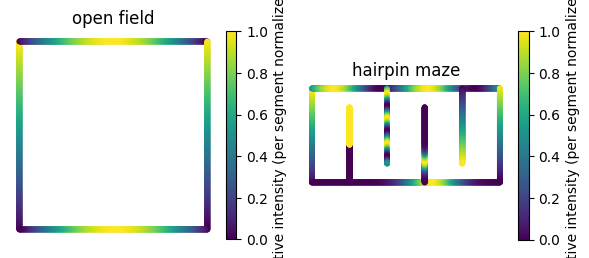

In [93]:
# 2D vision by raycasting — segment patterns via functions
import numpy as np
import matplotlib.pyplot as plt

# --------- Environment ---------
hairpin_maze = [
    [(0,0),(0,1)], [(0,1),(2,1)], [(2,1),(2,0)], [(0,0),(2,0)],  # outer boundaries
    [(2/5,0),(2/5,4/5)], [(4/5,1),(4/5,1/5)], [(6/5,0),(6/5,4/5)], [(8/5,1),(8/5,1/5)] # maze arms
]

open_field = [[(0,0),(0,1)],[(0,1),(1,1)],[(1,1),(1,0)],[(1,0),(0,0)]]

# --------- Sampling utilities ---------
def sample_segment(segment, n=300):
    (x0, y0), (x1, y1) = segment
    t = np.linspace(0.0, 1.0, n)
    x = x0 + (x1 - x0) * t
    y = y0 + (y1 - y0) * t
    return x, y, t

def normalize01(v):
    v = np.asarray(v, dtype=float)
    vmin, vmax = np.nanmin(v), np.nanmax(v)
    if np.isclose(vmax, vmin):
        return np.zeros_like(v)  # flat color if constant
    return (v - vmin) / (vmax - vmin)

# --------- Plotter ---------
def plot_environment_with_patterns(environment, funcs, ax = None,
                                   n_per_segment=400,
                                   point_size=8,
                                   show_outline=False):
    assert len(environment) == len(funcs), "funcs list must match number of segments"

    if ax is None:
      fig, ax = plt.subplots(figsize=(6, 6))

    scatters = []

    if show_outline:
        for seg in environment:
            xs, ys, _ = sample_segment(seg, n=2)
            ax.plot(xs, ys, linewidth=1, color="black")

    for seg, f in zip(environment, funcs):
        x, y, t = sample_segment(seg, n=n_per_segment)
        f = f if f is not None else (lambda u: u)
        raw = np.array([f(u) for u in t])
        cvals = normalize01(raw)
        sc = ax.scatter(x, y, c=cvals, s=point_size, cmap="viridis")
        scatters.append(sc)

    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

    if scatters:
        cbar = plt.colorbar(scatters[-1], ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("Relative intensity (per segment normalized)")

    return ax
# --------- Example intensity functions ---------
def linear(t): return t
def reverse_linear(t): return 1 - t
def sinusoid(t): return np.sin(2*np.pi*2*t)
def gaussian_bump(t, mu=0.5, sigma=0.12): return np.exp(-0.5*((t - mu)/sigma)**2)
def step(t): return 0.0 if t < 0.5 else 1.0

# Assign patterns to the 8 segments

#simplest case

#flexible for more complex environmets
hairpin_features = [
    linear,                        # left wall
    sinusoid,                      # top wall
    reverse_linear,                # right wall
    lambda t: gaussian_bump(t, 0.65, 0.1),  # bottom wall
    step,                          # first arm
    lambda t: np.sin(2*np.pi*3*t), # second arm
    lambda t: gaussian_bump(t, 0.3, 0.08),  # third arm
    lambda t: 0.2 + 0.6*t          # fourth arm
]
open_field_features = [linear, #left wall
                       lambda t: gaussian_bump(t, 0.5, 0.5), #top wall
                       reverse_linear, #right wall
                       lambda t: gaussian_bump(t, 0.5, 0.5)] #bottom wall

# --------- Show env ---------
fig, ax = plt.subplots(1,2, figsize=(6, 6))
ax[0] = plot_environment_with_patterns(open_field, open_field_features, ax = ax[0], n_per_segment=500, point_size=10)
ax[0].set(title ='open field')

ax[1] = plot_environment_with_patterns(hairpin_maze, hairpin_features, ax = ax[1], n_per_segment=500, point_size=10)
ax[1].set(title = 'hairpin maze')
fig.tight_layout()



In [94]:
## functions for 2D raycasting ##

import numpy as np

eps = 0.00001

def get_ray(position, angle, radius = 10):
    '''returns a ray as a list of tuples (start point and end point)
    Parameters
    ---------
    Angle: int
      angle of ray relative to agent in degrees'''
    endpoint = (position[0] + radius * np.cos(np.pi / 180 * angle),
                position[1] + radius * np.sin(np.pi / 180 * angle))
    return np.stack([position, endpoint])

def get_intersection_point(ray, segment, smallest_r=None):
  '''Honestly just copying some hard-coded geometry.
    Finding intersection points of two line segments.'''
  #initialise outputs as None
  intersection_point = None
  r = None
  A, B = segment    # segment is a list of two tuples [(x1, y1), (x2, y2)]
  C, D = ray    # ray is a list of two tuples [(x3, y3), (x4, y4)]

  denominator = (D[0] - C[0]) * (B[1] - A[1]) - (B[0] - A[0]) * (D[1] - C[1])

  if abs(denominator) < eps: # Avoid division by zero
      return None, None

  r = ((B[0] - A[0]) * (C[1] - A[1]) - (C[0] - A[0]) * (B[1] - A[1])) / denominator

  if (r + eps) < 0:
      return None, None
  if smallest_r is not None and smallest_r < r:
      return None, None

  s = ((A[0] - C[0]) * (D[1] - C[1]) - (D[0] - C[0]) * (A[1] - C[1])) / denominator

  if (s + eps) < 0 or (s - eps) > 1:
      return None, None

  # Return a tuple (x, y, r)
  intersection_point = ( s * (B[0] - A[0]) + A[0],
                          s * (B[1] - A[1]) + A[1])
  return intersection_point, r

def project_to_segment(intersection_point,segment):
  '''Takes 2D coordinate along segment and projects onto segment.
  Returns 1D number corresponding to how far along segment you are.
  This is a scalar projection and exactly what dot products are for.'''
  segment_vector = np.array(segment[1]) - np.array(segment[0])
  point_vector = np.array(intersection_point) - np.array(segment[0])
  scalar_projection = np.dot(point_vector, segment_vector) / np.linalg.norm(segment_vector)
  return scalar_projection


def get_closest_intersection_points(rays, segments, pattern_funcs):
  '''Take a list of rays and segments
    returns the intersection point of each ray to the nearest segment, alongside distance. '''
  all_points = []
  all_distances = []
  all_features = []
  for ray in rays:
    ray_points = []
    ray_distances = []
    ray_features = []
    for i, segment in enumerate(segments):
      intersection_point, distance = get_intersection_point(ray, segment)
      if intersection_point is not None:
        ray_points.append(intersection_point)
        ray_distances.append(distance)
        ray_features.append(pattern_funcs[i](project_to_segment(intersection_point,segment)))
    if len(ray_points)>0:
      nearest_point = ray_points[np.argmin(ray_distances)]
      all_points.append(ray_points[np.argmin(ray_distances)])
      all_distances.append(ray_distances[np.argmin(ray_distances)])
      all_features.append(ray_features[np.argmin(ray_distances)])

  return all_points, all_distances, all_features



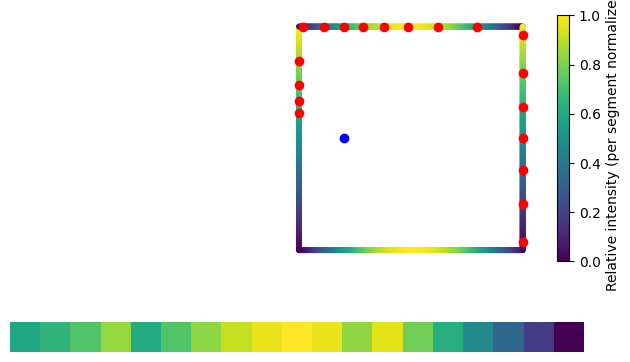

In [95]:
## Testing
current_position = (0.2,0.5)

fig, ax = plt.subplots(2,1)

ax[0] = plot_environment_with_patterns(open_field, open_field_features, ax = ax[0], n_per_segment=500, point_size=10)
ax[0].scatter(current_position[0],current_position[1], color ='blue', zorder = 1)
head_direction = -30
angles = np.linspace(0,180,19) +head_direction
rays = [get_ray(current_position, x, radius = 20) for x in angles]
intersection_points, distances, features = get_closest_intersection_points(rays, open_field, open_field_features)

for point in intersection_points:
    ax[0].scatter(point[0],point[1], color ='red', zorder =3)

#inverting indices below will render left-right rather than along the counter-clockwise angle
feature_img = np.array(features)[None,::-1]
#distace_img = np.array(distances)[None,::-1]
ax[1].imshow(feature_img, origin = 'lower')
ax[1].axis('off')
#ax[2].imshow(distace_img, origin = 'lower', cmap = 'jet')
#ax[2].axis('off')
fig.tight_layout()

## Trajectories with RatInABox

In [1]:
# Let's generate a trajectory with RatInABox!

!pip install RatInABox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 31.5 MB/s eta 0:00:00


100%|██████████| 100000/100000 [02:15<00:00, 738.05it/s]


(<Figure size 250x250 with 1 Axes>, <Axes: >)

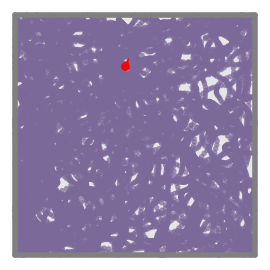

In [91]:
# leverage ratinabox to generate trajectory data and inputs
import ratinabox as riab
from tqdm import tqdm
import pandas as pd


#hairpin = riab.Environment(params = {'boundary':[[0,0],[0,1],[2,1],[2,0],[0,0]],
#                                  'walls':[[[2/5,0],[2/5,4/5]], [[4/5,5/5],[4/5,1/5]], [[6/5,0],[6/5,4/5]], [[8/5,1],[8/5,1/5]]]})

env = riab.Environment() #params = {'boundary':[[0,0],[0,1],[2,1],[2,0],[0,0]]} if using hairpin_maze to enlarge boundary
env.walls = np.array(open_field)
#env.plot_environment()
Ag = riab.Agent(env, params = {'dt':1/60})

traj_length = 100000
for i in tqdm(range(traj_length)):
  Ag.update()

history_df = pd.DataFrame(Ag.history)
Ag.plot_trajectory()

In [92]:
# now we have positions, velocities, and head directions.
# We now run over position and head direction to get the visual features at each time point
import numpy as np
history_df['hd_degrees'] = history_df['head_direction'].apply(lambda x: np.rad2deg(np.arctan2(x[1],x[0])))
angles = np.linspace(0,180,32)
example_df = history_df.iloc[0:3]
velocities = []
visual_features = []
distances = []
for step in tqdm(history_df.itertuples()):
  #step is a pandas series with hd_degrees, pos, and vel attributes
  head_direction = step.hd_degrees
  rays = [get_ray(step.pos, x+head_direction, radius = 20) for x in angles]
  intersection_points, distances, features = get_closest_intersection_points(rays, env.walls, open_field_features)
  action_vector = [np.deg2rad(head_direction), np.linalg.norm(step.vel)] #head_direction + speed
  sensory_vector = np.stack(features) # visual feature for each ray
  distance_vector = np.stack(distances) # distance to boundary for each ray
  velocities.append(action_vector)
  visual_features.append(sensory_vector)
  distances.append(distance_vector) #might be superfluous

sensory_inputs = np.array(visual_features)
true_velocities = np.array(velocities)

100000it [05:25, 306.95it/s]


# Learning to integrate velocity



